# 🗽 Modelling

In [2]:
from sklearn.cluster import DBSCAN

def apply_dbscan(data, eps=0.5, min_samples=4):
  dbscan = DBSCAN(eps=eps, min_samples=min_samples)
  computed_clusters = dbscan.fit_predict(data)

  n_clusters = len(set(computed_clusters)) - (1 if -1 in computed_clusters else 0)
  n_noise = list(computed_clusters).count(-1)

  print(f"DBSCAN Params | EPS: {eps}, min_sample: {min_samples}")
  print(f"* Cluster Count: {n_clusters}")
  print(f"* Noise Points: {n_noise}")

  return {
      'clusters': computed_clusters,
      'n_clusters': n_clusters,
      'n_noise': n_noise
  }

DBSCAN Params | EPS: 0.5, min_sample: 4
* Cluster Count: 51
* Noise Points: 7


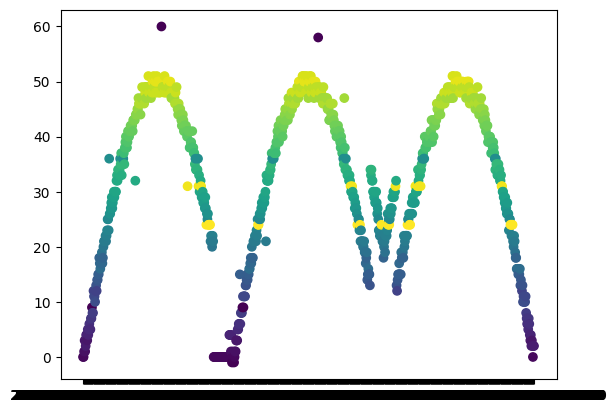

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load DataSet
synthetic_ts_df = pd.read_csv('generated_dataset.csv')

clusters = apply_dbscan(
    data=synthetic_ts_df['value'].values.reshape(-1, 1),
    eps=0.5,
    min_samples=4
)['clusters']

plt.scatter(synthetic_ts_df['timestamp'], synthetic_ts_df['value'], c=clusters, cmap='viridis')